# Importing Necessary Libraries:

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.utils import to_categorical
from keras import metrics
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum
from keras.layers.core import Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight


import os
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
import numpy as np

import cv2
import nibabel as nib
from PIL import Image
import tensorflow 
import tensorflow.keras as keras

import skimage.io

In [ ]:
!pip install SimpleITK
import SimpleITK

# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Path to training images

In [ ]:
path="/content/gdrive/MyDrive/MICCAI_BraTS_2018_Data_Training/HGG/"

# All folders in our data

In [ ]:
ids=next(os.walk(path))[1]
print(ids)


['Brats18_2013_10_1', 'Brats18_2013_11_1', 'Brats18_2013_12_1', 'Brats18_2013_13_1', 'Brats18_2013_14_1', 'Brats18_2013_17_1', 'Brats18_2013_18_1', 'Brats18_2013_19_1', 'Brats18_2013_20_1', 'Brats18_2013_21_1', 'Brats18_2013_22_1', 'Brats18_2013_23_1', 'Brats18_2013_25_1', 'Brats18_2013_26_1', 'Brats18_2013_27_1', 'Brats18_2013_2_1', 'Brats18_2013_3_1', 'Brats18_2013_4_1', 'Brats18_2013_5_1', 'Brats18_2013_7_1', 'Brats18_CBICA_AAB_1', 'Brats18_CBICA_AAG_1', 'Brats18_CBICA_AAL_1', 'Brats18_CBICA_AAP_1', 'Brats18_CBICA_ABB_1', 'Brats18_CBICA_ABE_1', 'Brats18_CBICA_ABM_1', 'Brats18_CBICA_ABN_1', 'Brats18_CBICA_ABO_1', 'Brats18_CBICA_ABY_1', 'Brats18_CBICA_ALN_1', 'Brats18_CBICA_ALU_1', 'Brats18_CBICA_ALX_1', 'Brats18_CBICA_AME_1', 'Brats18_CBICA_AMH_1', 'Brats18_CBICA_ANG_1', 'Brats18_CBICA_ANI_1', 'Brats18_CBICA_ANP_1', 'Brats18_CBICA_ANZ_1', 'Brats18_CBICA_AOD_1', 'Brats18_CBICA_AOH_1', 'Brats18_CBICA_AOO_1', 'Brats18_CBICA_AOP_1', 'Brats18_CBICA_AOZ_1', 'Brats18_CBICA_APR_1', 'Brats18_

In [ ]:
len(ids)

210

# Function to standardize images

In [ ]:
def standardize(image):

    standardized_image = np.zeros(image.shape)

    
   
        # iterate over the `z` dimension
    for z in range(image.shape[2]):
        # get a slice of the image at z-th dimension `z`
        image_slice = image[:,:,z]

        # subtract the mean from image_slice
        centered = image_slice - np.mean(image_slice)
       
        # divide by the standard deviation (only if it is different from zero)
        if(np.std(centered)!=0):
            centered = centered/np.std(centered)

        # update  the slice of standardized image
        standardized_image[:, :,z] = centered


    return standardized_image

# Convolution block

In [ ]:
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)

  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(X)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)
  
  return X

# UNet 3D Architecture:

In [ ]:
def Unet_3d(input_img, n_filters = 8, dropout = 0.2, batch_norm = True):

    c1 = conv_block(input_img,n_filters,3,batch_norm)
    p1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv_block(p1,n_filters*2,3,batch_norm);
    p2 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv_block(p2,n_filters*4,3,batch_norm);
    p3 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv_block(p3,n_filters*8,3,batch_norm);
    p4 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv_block(p4,n_filters*16,3,batch_norm);

    u6 = Conv3DTranspose(n_filters*8, (3,3,3), strides=(2, 2, 2), padding='same')(c5);
    u6 = concatenate([u6,c4]);
    c6 = conv_block(u6,n_filters*8,3,batch_norm)
    c6 = Dropout(dropout)(c6)
    u7 = Conv3DTranspose(n_filters*4,(3,3,3),strides = (2,2,2) , padding= 'same')(c6);

    u7 = concatenate([u7,c3]);
    c7 = conv_block(u7,n_filters*4,3,batch_norm)
    c7 = Dropout(dropout)(c7)
    u8 = Conv3DTranspose(n_filters*2,(3,3,3),strides = (2,2,2) , padding='same')(c7);
    u8 = concatenate([u8,c2]);

    c8 = conv_block(u8,n_filters*2,3,batch_norm)
    c8 = Dropout(dropout)(c8)
    u9 = Conv3DTranspose(n_filters,(3,3,3),strides = (2,2,2) , padding='same')(c8);

    u9 = concatenate([u9,c1]);

    c9 = conv_block(u9,n_filters,3,batch_norm)
    outputs = Conv3D(4, (1,1,1), activation='softmax')(c9)
    print("!!!!!!!!!!!!!!!!!!!")
    print(outputs.shape)
    model = Model(inputs=input_img, outputs=outputs)

    return model


# Dice Co-efficient and Dice-Loss

In [ ]:
def dice_coef(y_true, y_pred, epsilon=0.00001):
    
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))


In [ ]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# Preparing the model:

In [ ]:
input_img = Input((128,128,128,4))
model = Unet_3d(input_img,8,0.1,True)
learning_rate = 0.01
decay_rate = 0.000001
model.compile(optimizer=Adam(lr=learning_rate, decay = decay_rate), loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

!!!!!!!!!!!!!!!!!!!
(None, 128, 128, 128, 4)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 872         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 128 32          conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 128 0           batch_normalization[0][0]        
_________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
import tensorflow.keras as keras
import tensorflow


In [ ]:
all_images=os.listdir(path)

# Number of images used:

In [ ]:
nou=40 #Number of images used 

In [ ]:
# This function resizes 3d images
def my_resize_func(img):
    out_im=[]
    for i in range(15,143):
        im1=img[:,:,i]
        im1=cv2.resize(im1,(128,128))
        out_im.append(im1)
    return np.array(out_im,np.float32)


# A sample image:

In [ ]:
path1=path+all_images[2]
path1
m=os.listdir(path1)
t=path1+"/"+m[3]
t

'/content/gdrive/MyDrive/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_12_1/Brats18_2013_12_1_t1ce.nii'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


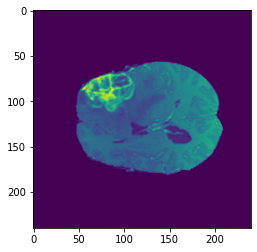

In [ ]:
imm=nib.load(t)
imm2=imm.get_data()
imm2=standardize(imm2)
plt.imshow(imm2[:,:,80])

# Preparing the train images:

In [ ]:

y_train=[]
flair=[]
t1=[]
t2=[]
t1ce=[]
# data preprocessing starts here
for image_num in range(nou):

    x = all_images[image_num]
    print(x)
    folder_path = path + x;
    modalities = os.listdir(folder_path)
    modalities.sort()
    #data = []
    
    for j in range(len(modalities)):

        #print(modalities[j])
        
        image_path = folder_path + '/' + modalities[j]
        if (image_path[-7:-1] + image_path[-1] == 'seg.nii'): #Prepares the ground truth

            img = nib.load(image_path)
            image_data2 = img.get_data()
            image_data2 = np.asarray(image_data2)
            #image_data2=skimage.io.imread(image_path,plugin="simpleitk")
            image_data2=standardize(image_data2)
            #image_data2=my_resize_func(image_data2)
            image_data2=np.expand_dims(image_data2,axis=-1)
            y_train.append(image_data2)
        if (image_path[-9:-1] + image_path[-1] == 'flair.nii'): #Prepares the Flair modality

            img = nib.load(image_path)
            image_data2 = img.get_data()
            image_data2 = np.asarray(image_data2)
            #image_data2=skimage.io.imread(image_path,plugin="simpleitk")
            image_data2=standardize(image_data2)
            #image_data2=my_resize_func(image_data2)
            image_data2=np.expand_dims(image_data2,axis=-1)
            flair.append(image_data2)
        if (image_path[-6:-1] + image_path[-1] == 't1.nii'): #Prepares the t1 modality

            img = nib.load(image_path)
            image_data2 = img.get_data()
            image_data2 = np.asarray(image_data2)
            #image_data2=skimage.io.imread(image_path,plugin="simpleitk")
            image_data2=standardize(image_data2)
            #image_data2=my_resize_func(image_data2)
            image_data2=np.expand_dims(image_data2,axis=-1)
            t1.append(image_data2)
        if (image_path[-6:-1] + image_path[-1] == 't2.nii'): # Prepares the t2 modality

            img = nib.load(image_path);
            image_data2 = img.get_data()
            image_data2 = np.asarray(image_data2)
            #image_data2=skimage.io.imread(image_path,plugin="simpleitk")
            image_data2=standardize(image_data2)
            #image_data2=my_resize_func(image_data2)
            image_data2=np.expand_dims(image_data2,axis=-1)
            t2.append(image_data2)
        if (image_path[-8:-1] + image_path[-1] == 't1ce.nii'): #Prepares the t1ce modality

            img = nib.load(image_path)
            image_data2 = img.get_data()
            image_data2 = np.asarray(image_data2)
            #image_data2=skimage.io.imread(image_path,plugin="simpleitk")
            image_data2=standardize(image_data2)
            #image_data2=my_resize_func(image_data2)
            image_data2=np.expand_dims(image_data2,axis=-1)
            t1ce.append(image_data2)

        
y_train=np.array(y_train,np.float32)
y_train=y_train[:,60:188,60:188,15:143]
print(y_train.shape)

flair=np.array(flair,np.float32)
flair=flair[:,60:188,60:188,15:143,:]
print(flair.shape)

t1=np.array(t1,np.float32)
t1=t1[:,60:188,60:188,15:143,:]
print(t1.shape)

t1ce=np.array(t1ce,np.float32)
t1ce=t1ce[:,60:188,60:188,15:143,:]
print(t1ce.shape)

t2=np.array(t2,np.float32)
t2=t2[:,60:188,60:188,15:143,:]
print(t2.shape)


        

        

Brats18_2013_10_1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.datao

Brats18_2013_11_1
Brats18_2013_12_1
Brats18_2013_13_1
Brats18_2013_14_1
Brats18_2013_17_1
Brats18_2013_18_1
Brats18_2013_19_1
Brats18_2013_20_1
Brats18_2013_21_1
Brats18_2013_22_1
Brats18_2013_23_1
Brats18_2013_25_1
Brats18_2013_26_1
Brats18_2013_27_1
Brats18_2013_2_1
Brats18_2013_3_1
Brats18_2013_4_1
Brats18_2013_5_1
Brats18_2013_7_1
Brats18_CBICA_AAB_1
Brats18_CBICA_AAG_1
Brats18_CBICA_AAL_1
Brats18_CBICA_AAP_1
Brats18_CBICA_ABB_1
Brats18_CBICA_ABE_1
Brats18_CBICA_ABM_1
Brats18_CBICA_ABN_1
Brats18_CBICA_ABO_1
Brats18_CBICA_ABY_1
Brats18_CBICA_ALN_1
Brats18_CBICA_ALU_1
Brats18_CBICA_ALX_1
Brats18_CBICA_AME_1
Brats18_CBICA_AMH_1
Brats18_CBICA_ANG_1
Brats18_CBICA_ANI_1
Brats18_CBICA_ANP_1
Brats18_CBICA_ANZ_1
Brats18_CBICA_AOD_1
(40, 128, 128, 128, 1)
(40, 128, 128, 128, 1)
(40, 128, 128, 128, 1)
(40, 128, 128, 128, 1)
(40, 128, 128, 128, 1)


# Preparing the X_train:

In [ ]:
X_train=np.concatenate((flair,t1,t2,t1ce),axis=-1)
X_train.shape

(40, 128, 128, 128, 4)

# Training image: Flair Modality

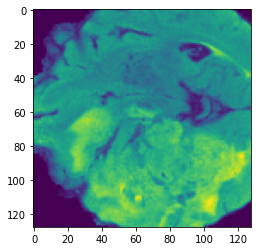

In [ ]:
plt.imshow(X_train[10,:,:,50,0])

# Ground Truth:

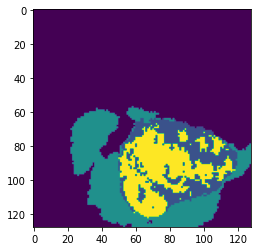

In [ ]:
plt.imshow(y_train[10,:,:,50])

# Training:

In [ ]:
history1=model.fit(X_train,y_train,validation_split=0.2,batch_size=1,epochs=50)

Epoch 1/50
32/32 [==============================] - 288s 8s/step - loss: 0.9513 - dice_coef: 0.0487 - val_loss: 0.9574 - val_dice_coef: 0.0426
Epoch 2/50
32/32 [==============================] - 262s 8s/step - loss: 0.9512 - dice_coef: 0.0488 - val_loss: 0.9688 - val_dice_coef: 0.0312
Epoch 3/50
32/32 [==============================] - 261s 8s/step - loss: 0.9469 - dice_coef: 0.0531 - val_loss: 0.9670 - val_dice_coef: 0.0330
Epoch 4/50
32/32 [==============================] - 261s 8s/step - loss: 0.9455 - dice_coef: 0.0545 - val_loss: 0.9694 - val_dice_coef: 0.0306
Epoch 5/50
32/32 [==============================] - 262s 8s/step - loss: 0.9479 - dice_coef: 0.0521 - val_loss: 0.9692 - val_dice_coef: 0.0308
Epoch 6/50
32/32 [==============================] - 261s 8s/step - loss: 0.9463 - dice_coef: 0.0537 - val_loss: 0.9692 - val_dice_coef: 0.0308
Epoch 7/50
32/32 [==============================] - 263s 8s/step - loss: 0.9501 - dice_coef: 0.0499 - val_loss: 0.9519 - val_dice_coef: 0.0481

In [ ]:
model.save_weights("/content/gdrive/MyDrive/working models brats 18/3dunet1.h5")

# Test image: 200th image

In [ ]:
y_test=[]
flair_t=[]
t1_t=[]
t1ce_t=[]
t2_t=[]
x = all_images[200] # Entering the folder
print(x)
folder_path = path + x;
modalities = os.listdir(folder_path) # All modalities
modalities.sort()
#data = []

for j in range(len(modalities)):

    #print(modalities[j])

    image_path = folder_path + '/' + modalities[j] #Accesing the image
    if (image_path[-7:-1] + image_path[-1] == 'seg.nii'):

        img = nib.load(image_path);
        image_data2 = img.get_data()
        image_data2 = np.asarray(image_data2)
        #image_data2=skimage.io.imread(image_path,plugin="simpleitk")
        image_data2=standardize(image_data2)
        #image_data2=my_resize_func(image_data2)
        image_data2=np.expand_dims(image_data2,axis=-1)
        y_test.append(image_data2)
    if (image_path[-9:-1] + image_path[-1] == 'flair.nii'):

        img = nib.load(image_path);
        image_data2 = img.get_data()
        image_data2 = np.asarray(image_data2)
        #image_data2=skimage.io.imread(image_path,plugin="simpleitk")
        image_data2=standardize(image_data2)
        #image_data2=my_resize_func(image_data2)
        image_data2=np.expand_dims(image_data2,axis=-1)
        flair_t.append(image_data2)
    if (image_path[-6:-1] + image_path[-1] == 't1.nii'):

        img = nib.load(image_path);
        image_data2 = img.get_data()
        image_data2 = np.asarray(image_data2)
        #image_data2=skimage.io.imread(image_path,plugin="simpleitk")
        image_data2=standardize(image_data2)
        #image_data2=my_resize_func(image_data2)
        image_data2=np.expand_dims(image_data2,axis=-1)
        t1_t.append(image_data2)
    if (image_path[-6:-1] + image_path[-1] == 't2.nii'):

        img = nib.load(image_path);
        image_data2 = img.get_data()
        image_data2 = np.asarray(image_data2)
        #image_data2=skimage.io.imread(image_path,plugin="simpleitk")
        image_data2=standardize(image_data2)
        #image_data2=my_resize_func(image_data2)
        image_data2=np.expand_dims(image_data2,axis=-1)
        t2_t.append(image_data2)
    if (image_path[-8:-1] + image_path[-1] == 't1ce.nii'):

        img = nib.load(image_path);
        image_data2 = img.get_data()
        image_data2 = np.asarray(image_data2)
        #image_data2=skimage.io.imread(image_path,plugin="simpleitk")
        image_data2=standardize(image_data2)
        #image_data2=my_resize_func(image_data2)
        image_data2=np.expand_dims(image_data2,axis=-1)
        t1ce_t.append(image_data2)

        
y_test=np.array(y_test,np.float32)
y_test=y_test[:,60:188,60:188,15:143,:]
print(y_test.shape)

flair_t=np.array(flair_t,np.float32)
flair_t=flair_t[:,60:188,60:188,15:143,:]
print(flair_t.shape)

t1_t=np.array(t1_t,np.float32)
t1_t=t1_t[:,60:188,60:188,15:143,:]
print(t1_t.shape)

t1ce_t=np.array(t1ce_t,np.float32)
t1ce_t=t1ce_t[:,60:188,60:188,15:143,:]
print(t1ce_t.shape)

t2_t=np.array(t2_t,np.float32)
t2_t=t2_t[:,60:188,60:188,15:143,:]
print(t2_t.shape)


Brats18_TCIA08_205_1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.datao

(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)


In [ ]:
X_test=np.concatenate((flair_t,t1_t,t2_t,t1ce_t),axis=-1)

# Flair modality of the test image:

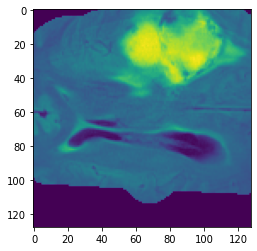

In [ ]:
plt.imshow(X_test[0,:,:,70,0])

# Ground Truth: 

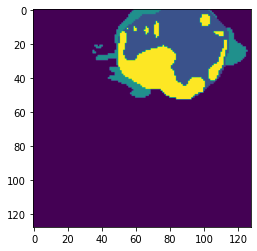

In [ ]:
plt.imshow(y_test[0,:,:,70,0])

# Predictions:

In [ ]:
pred=model.predict(X_test)
pred=np.argmax(pred,axis=-1)
pred.shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


(1, 128, 128, 128)

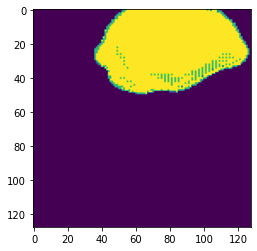

In [ ]:
plt.imshow(pred[0,:,:,70])